In [7]:
import numpy as np
from scipy.stats import pearsonr, f_oneway
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestCentroid

# TCGA PCA on all tissue types

We will do harmonization of all of our TCGA samples here before performing principal component analysis. The goal of this analysis is to see whether PCA will help us stratify cell types. 

In [8]:
# Load gene counts and metadata in
COAD_READ_counts = pd.read_csv('/pollard/home/aravi1/crc_gene_counts.tsv', sep='\t')
COAD_READ_metadata = pd.read_csv('/pollard/home/aravi1/crc_metadata.tsv', sep='\t')

BLCA_counts = pd.read_csv('/pollard/home/aravi1/TCGA_matrices/TCGA-BLCA_counts.tsv', sep='\t')
BLCA_metadata = pd.read_csv('/pollard/home/aravi1/TCGA_matrices/TCGA-BLCA_metadata.tsv', sep='\t')

KIRC_counts = pd.read_csv('/pollard/home/aravi1/TCGA_matrices/TCGA-KIRC_counts.tsv', sep='\t')
KIRC_metadata = pd.read_csv('/pollard/home/aravi1/TCGA_matrices/TCGA-KIRC_metadata.tsv', sep='\t')
KIRC_metadata = KIRC_metadata[KIRC_metadata.columns[1:8]]

LGG_counts = pd.read_csv('/pollard/home/aravi1/TCGA_matrices/TCGA-LGG_counts.tsv', sep='\t')
LGG_metadata = pd.read_csv('/pollard/home/aravi1/TCGA_matrices/TCGA-LGG_metadata.tsv', sep='\t')

LUAD_counts = pd.read_csv('/pollard/home/aravi1/TCGA_matrices/TCGA-LUAD_counts.tsv', sep='\t')
LUAD_metadata = pd.read_csv('/pollard/home/aravi1/TCGA_matrices/TCGA-LUAD_metadata.tsv', sep='\t')

LUSC_counts = pd.read_csv('/pollard/home/aravi1/TCGA_matrices/TCGA-LUSC_counts.tsv', sep='\t')
LUSC_metadata = pd.read_csv('/pollard/home/aravi1/TCGA_matrices/TCGA-LUSC_metadata.tsv', sep='\t')

PRAD_counts = pd.read_csv('/pollard/home/aravi1/TCGA_matrices/TCGA-PRAD_counts.tsv', sep='\t')
PRAD_metadata = pd.read_csv('/pollard/home/aravi1/TCGA_matrices/TCGA-PRAD_metadata.tsv', sep='\t')


In [9]:
# Rename count columns to each biosample ID 
COAD_READ_counts.columns.values[3:] = COAD_READ_metadata['File.Name'].str.split('.').str[0]
BLCA_counts.columns.values[3:] = BLCA_metadata['File Name'].str.split('.').str[0]
KIRC_counts.columns.values[3:] = KIRC_metadata['File.Name'].str.split('.').str[0]
LGG_counts.columns.values[3:] = LGG_metadata['File.Name'].str.split('.').str[0]
LUAD_counts.columns.values[3:] = LUAD_metadata['File.Name'].str.split('.').str[0]
LUSC_counts.columns.values[3:] = LUSC_metadata['File.Name'].str.split('.').str[0]
PRAD_counts.columns.values[3:] = PRAD_metadata['File.Name'].str.split('.').str[0]

COAD_READ_metadata['sample_id'] = COAD_READ_metadata['File.Name'].str.split('.').str[0]
BLCA_metadata['sample_id'] = BLCA_metadata['File Name'].str.split('.').str[0]
KIRC_metadata['sample_id'] = KIRC_metadata['File.Name'].str.split('.').str[0]
LGG_metadata['sample_id'] = LGG_metadata['File.Name'].str.split('.').str[0]
LUAD_metadata['sample_id'] = LUAD_metadata['File.Name'].str.split('.').str[0]
LUSC_metadata['sample_id'] = LUSC_metadata['File.Name'].str.split('.').str[0]
PRAD_metadata['sample_id'] = PRAD_metadata['File.Name'].str.split('.').str[0]

COAD_READ_samples = COAD_READ_metadata['File.Name'][COAD_READ_metadata['Project'].str.contains('TCGA')].str.split('.').str[0]
COAD_READ_counts = COAD_READ_counts[COAD_READ_counts.columns.intersection(COAD_READ_samples)]
COAD_READ_metadata = COAD_READ_metadata[COAD_READ_metadata['sample_id'].isin(COAD_READ_samples)]

In [10]:
metadata = pd.concat([COAD_READ_metadata[['Project', 'sample_id']], 
                     BLCA_metadata[['Project', 'sample_id']], 
                     KIRC_metadata[['Project', 'sample_id']], 
                     LGG_metadata[['Project', 'sample_id']], 
                     LUAD_metadata[['Project', 'sample_id']],
                     LUSC_metadata[['Project', 'sample_id']],
                     PRAD_metadata[['Project', 'sample_id']]], axis=0)

counts = pd.concat([BLCA_counts,
                    COAD_READ_counts, 
                    KIRC_counts.iloc[:,3:], 
                    LGG_counts.iloc[:,3:], 
                    LUAD_counts.iloc[:,3:],
                    LUSC_counts.iloc[:,3:],
                    PRAD_counts.iloc[:,3:]], axis=1)

In [11]:
counts = counts[counts.columns.intersection(metadata['sample_id'])]

In [12]:
counts.shape

(60660, 3981)

In [7]:
counts.to_csv("/pollard/home/aravi1/all_cell_types/all_cell_type_counts.tsv.gz", sep='\t', header=True, index=None, compression="gzip")
metadata.to_csv("/pollard/home/aravi1/all_cell_types/all_cell_type_metadata.tsv", sep='\t', header = True)

OSError: Cannot save file into a non-existent directory: '/pollard/home/aravi1/all_cell_types'

In [13]:
normalization = True

if normalization == True:
    counts.iloc[:,3:] = np.log(counts.iloc[:,3:] + 0.00001)

## Metadata summary

In [14]:
%%html
<style>
table {float:left}
</style>

| Cohort | Samples | Cancer Type | 
|:------:|:---:|:-----------|
| COAD-READ | 695 | Adenocarcinoma |
| BLCA | 431 | Carcinoma | 
| KIRC | 614 | Carcinoma |
| LGG | 534 | Glioma |
| LUAD | 600 | Adenocarcinoma | 
| LUSC | 553 | Sarcoma |
| PRAD | 554 | Adenocarcinoma |
| **TOTAL** | **3981** |

In [15]:
pca = PCA(n_components=20, random_state = 150)
pca.fit(counts.iloc[:,3:])

explained_variance = pca.explained_variance_ratio_
total_explained_variance = explained_variance.sum()

Text(0, 0.5, 'Percent of Variance')

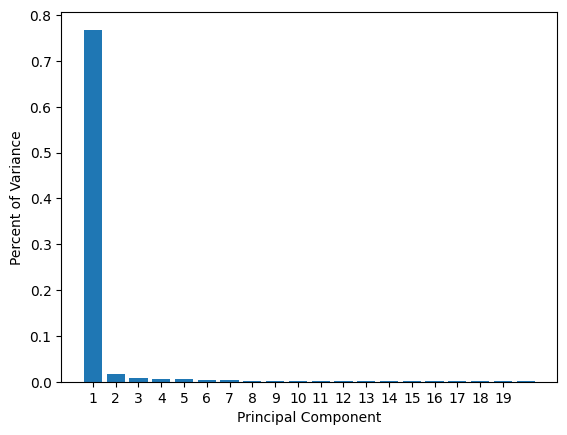

In [16]:
plt.bar(range(1, 21, 1), explained_variance)
plt.xticks(np.arange(1, 20, step=1))
plt.xlabel("Principal Component")
plt.ylabel("Percent of Variance")

In [17]:
PCA_df = pd.DataFrame(data=pca.components_.reshape(20,3978).T)

PCA_df['sample_id'] = counts.columns[3:]
PCA_df = pd.merge(PCA_df, metadata, on="sample_id", how="inner")
new_columns = pd.Series(['PC' + str(int(c) + 1) for c in PCA_df.columns[0:20]])
PCA_df = PCA_df.rename(columns=dict(zip(PCA_df.columns[0:20], new_columns)))

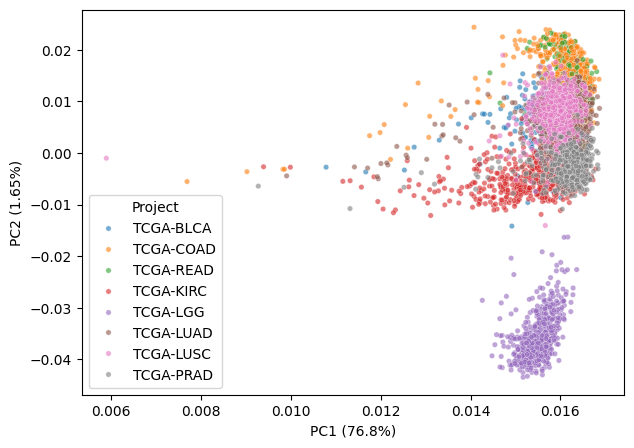

In [18]:
plt.figure(figsize=(7,5))
sns.scatterplot(x='PC1', y='PC2', hue='Project', data=PCA_df, s=15, alpha=0.6) 
plt.xlabel("PC1 (76.8%)")
plt.ylabel("PC2 (1.65%)")
plt.show()

As we can see here, most of the variation is being explained by the difference in clustering between the large-grade gliomas vs. other cell types. Let's filter out LGG samples and try PCA again to see whether we can get better cell-type stratification. (We don't get good stratification - deleted code) 

# Calculate centroids for each cluster

In [19]:
# Assuming 'clusters' is a list of lists where each sublist contains the indices of data points in that cluster
# 'data' is your dataset where each row represents a data point

projects = ['TCGA-BLCA','TCGA-COAD','TCGA-KIRC','TCGA-LGG','TCGA-LUAD','TCGA-LUSC','TCGA-PRAD','TCGA-READ']

def calculate_centroids(data, clusters):
    centroids = []
    for cluster_indices in clusters:
        # Select data points belonging to the current cluster
        print(cluster_indices)
        cluster_data = data[['PC1','PC2']][data['Project'] == cluster_indices]
        print(cluster_data.head())
        # Calculate centroid by taking the mean along the rows (axis=0)
        centroid = np.mean(cluster_data, axis=0)
        centroids.append(centroid)
    return centroids

tcga_centroids = calculate_centroids(PCA_df, projects)

TCGA-BLCA
        PC1       PC2
0  0.015623  0.011118
1  0.016178  0.010678
2  0.016070  0.004338
3  0.016206  0.004658
4  0.016224  0.010678
TCGA-COAD
          PC1       PC2
428  0.014723  0.016997
429  0.016411  0.013462
431  0.016697  0.011730
432  0.016105  0.021356
433  0.015277  0.019875
TCGA-KIRC
           PC1       PC2
1123  0.014812 -0.007157
1124  0.014774 -0.006982
1125  0.015960 -0.003622
1126  0.016239 -0.006639
1127  0.014804  0.000493
TCGA-LGG
           PC1       PC2
1737  0.015513 -0.035198
1738  0.015676 -0.037970
1739  0.015191 -0.033490
1740  0.015595 -0.019142
1741  0.015513 -0.034132
TCGA-LUAD
           PC1       PC2
2271  0.015952  0.011532
2272  0.015779  0.005107
2273  0.015663  0.005295
2274  0.016085  0.007639
2275  0.016116  0.011716
TCGA-LUSC
           PC1       PC2
2871  0.015761  0.004016
2872  0.016090  0.009139
2873  0.015510  0.011528
2874  0.016074  0.011091
2875  0.015660  0.013661
TCGA-PRAD
           PC1       PC2
3424  0.016219 -0.003823
3425 

In [20]:
tcga_centroids

[PC1    0.015845
 PC2    0.007731
 dtype: float64,
 PC1    0.015984
 PC2    0.015073
 dtype: float64,
 PC1    0.015428
 PC2   -0.004222
 dtype: float64,
 PC1    0.015505
 PC2   -0.035509
 dtype: float64,
 PC1    0.015984
 PC2    0.007045
 dtype: float64,
 PC1    0.015905
 PC2    0.007513
 dtype: float64,
 PC1    0.016145
 PC2   -0.002632
 dtype: float64,
 PC1    0.016157
 PC2    0.015378
 dtype: float64]

/tmp/ipykernel_324191/2595028049.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(centroid[0], centroid[1], marker='x', color='red')


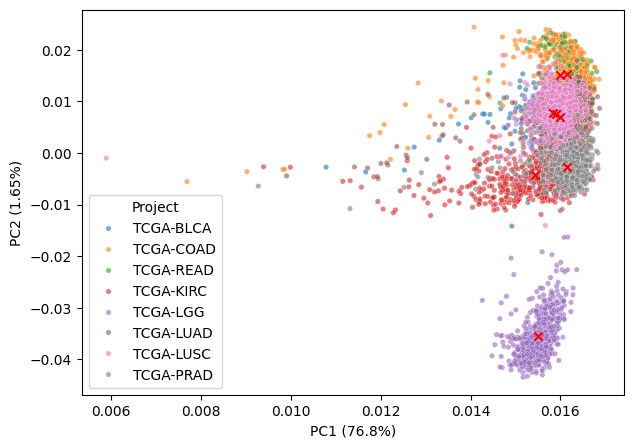

In [21]:
plt.figure(figsize=(7,5))
sns.scatterplot(x='PC1', y='PC2', hue='Project', data=PCA_df, s=15, alpha=0.6) 
for centroid in tcga_centroids:
    plt.scatter(centroid[0], centroid[1], marker='x', color='red')
plt.xlabel("PC1 (76.8%)")
plt.ylabel("PC2 (1.65%)")
plt.show()

In [22]:
def euclidean_distance(point1, point2):
    return np.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)

COAD_centroid = tcga_centroids[1]
coad_distances = pd.Series([euclidean_distance(COAD_centroid, centroid) for centroid in tcga_centroids])

READ_centroid = tcga_centroids[7]
read_distances = pd.Series([euclidean_distance(READ_centroid, centroid) for centroid in tcga_centroids])

/tmp/ipykernel_324191/291486560.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)


In [23]:
accuracies = pd.Series([0.62317, 0.61804, 0.59254, 0.52649, 0.60072, 0.59467, 0.5924, 0.61904])
dist_acc_table = pd.concat([pd.Series(read_distances), pd.Series(coad_distances), accuracies, pd.Series(projects)], axis=1)
dist_acc_table.columns = ['READ_distance', 'COAD_distance', 'Accuracy', 'Projects']


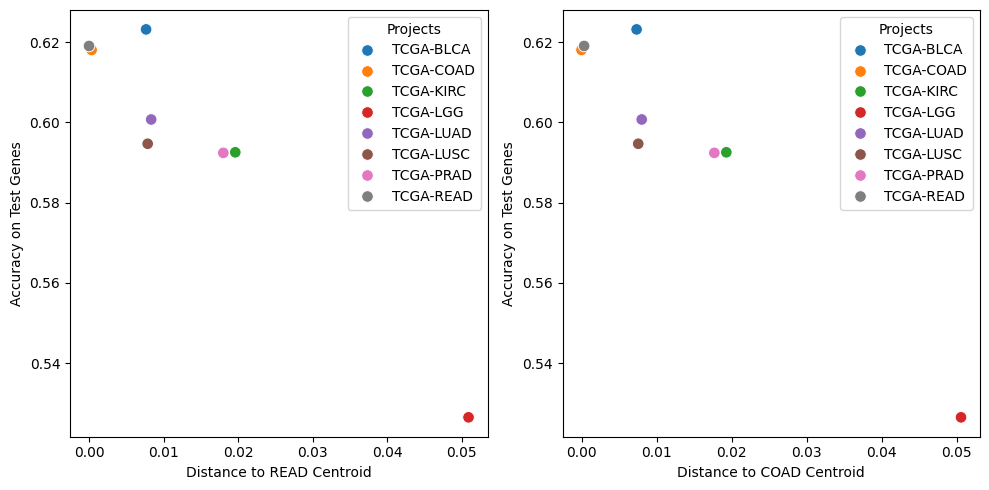

In [24]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.scatterplot(x='READ_distance', y='Accuracy', data=dist_acc_table, hue='Projects', s=70, ax=ax[0])
ax[0].set_xlabel('Distance to READ Centroid')
ax[0].set_ylabel("Accuracy on Test Genes")

sns.scatterplot(x='COAD_distance', y='Accuracy', data=dist_acc_table, hue='Projects', s=70, ax=ax[1])
ax[1].set_xlabel('Distance to COAD Centroid')
ax[1].set_ylabel("Accuracy on Test Genes")

plt.tight_layout()

# Show plot
plt.show()

## TCGA Comparison on Cancer-relevant Genes

In [25]:
accuracies = pd.Series([0.43923, 0.44547, 0.43986, 0.07051, 0.37962, 0.31996, 0.43757, 0.46349])
dist_acc_table = pd.concat([pd.Series(read_distances), pd.Series(coad_distances), accuracies, pd.Series(projects)], axis=1)
dist_acc_table.columns = ['READ_distance', 'COAD_distance', 'Accuracy', 'Projects']

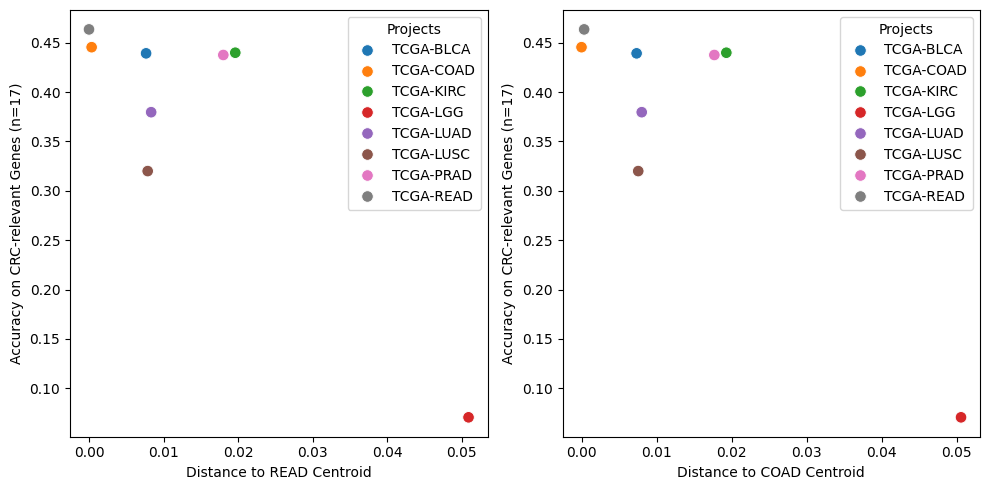

In [26]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.scatterplot(x='READ_distance', y='Accuracy', data=dist_acc_table, hue='Projects', s=70, ax=ax[0])
ax[0].set_xlabel('Distance to READ Centroid')
ax[0].set_ylabel("Accuracy on CRC-relevant Genes (n=17)")

sns.scatterplot(x='COAD_distance', y='Accuracy', data=dist_acc_table, hue='Projects', s=70, ax=ax[1])
ax[1].set_xlabel('Distance to COAD Centroid')
ax[1].set_ylabel("Accuracy on CRC-relevant Genes (n=17)")

plt.tight_layout()

# Show plot
plt.show()

### Compare loss/residuals of CRC-relevant gene predictions vs TCGA targets

In [27]:
outputs_targets = pd.read_csv('/pollard/home/aravi1/TCGA_matrices/TCGA_output_target.tsv', sep='\t')
# Calculate the squared errors for each sample
sse_targets = pd.DataFrame([((np.log(outputs_targets[c] + 0.00001) - np.log(outputs_targets['output'] + 0.00001)) ** 2) for c in outputs_targets.columns[2:]]).T
sse = sse_targets.sum()
# Calculate the MSE for each target
mse_targets = sse / len(outputs_targets)

In [28]:
outputs_targets

,gene_name,output,BLCA,COAD,KIRC,LGG,LUAD,LUSC,PRAD,READ
0,NRAS,79.125670,49.77870,63.35125,63.47025,44.01475,54.83500,69.6618,30.60315,62.3212
1,MSH2,35.492157,9.05060,9.24085,5.90840,7.49250,8.05150,11.1978,6.21530,9.2185
2,MSH6,4.614817,16.75030,14.70595,12.80960,13.84980,16.43820,29.1685,13.54520,14.2940
3,TGFBR2,87.915085,30.11485,60.70705,136.65270,20.18630,87.22440,36.3455,34.71835,68.6260
4,MLH1,52.889038,14.26130,11.05765,10.73220,16.88060,13.92895,12.8134,18.14235,12.3827
5,CTNNB1,1.985663,94.32455,160.63760,93.88295,102.19475,142.45615,120.1737,116.48765,170.4631
6,PIK3CA,28.946780,4.87500,3.27630,6.27015,7.07260,5.05165,9.4045,4.17735,3.3267
7,FBXW7,13.414454,5.44115,4.64850,5.25310,8.70470,6.50685,5.9648,4.36030,4.3478
8,APC,10.140308,5.59020,5.90580,11.05480,54.75545,7.63790,7.1264,8.53200,5.2405
9,PMS2,57.856903,5.71990,5.40220,8.90925,11.14510,6.42110,7.6785,7.13245,5.3957


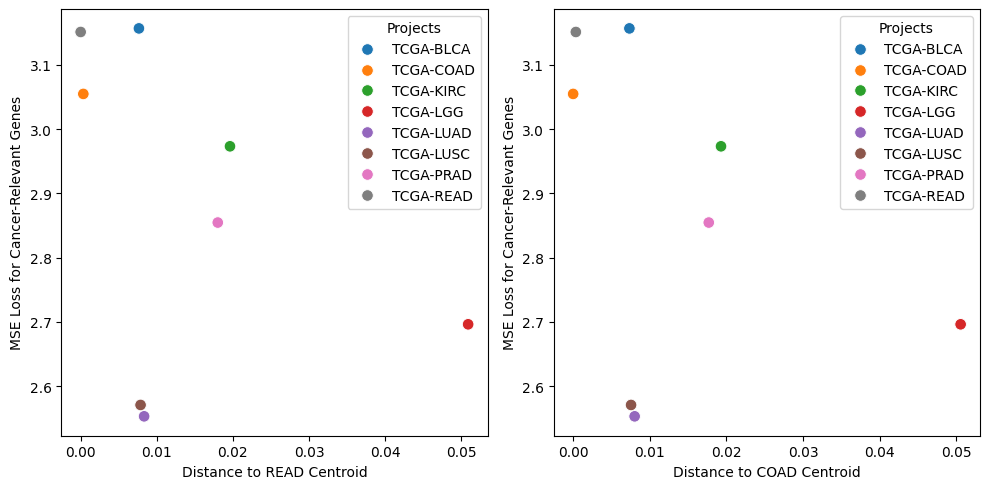

In [29]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

dist_acc_table['loss'] = mse_targets

sns.scatterplot(x='READ_distance', y='loss', data=dist_acc_table, hue='Projects', s=70, ax=ax[0])
ax[0].set_xlabel('Distance to READ Centroid')
ax[0].set_ylabel("MSE Loss for Cancer-Relevant Genes")

sns.scatterplot(x='COAD_distance', y='loss', data=dist_acc_table, hue='Projects', s=70, ax=ax[1])
ax[1].set_xlabel('Distance to COAD Centroid')
ax[1].set_ylabel("MSE Loss for Cancer-Relevant Genes")

plt.tight_layout()

# Show plot
plt.show()

In [30]:
[pearsonr(np.log(outputs_targets['output']), np.log(outputs_targets[c])) for c in outputs_targets.columns[2:]]

[PearsonRResult(statistic=0.43924313980747864, pvalue=0.0777254299904369),
 PearsonRResult(statistic=0.44548389328923693, pvalue=0.07311992444640326),
 PearsonRResult(statistic=0.4398710802665345, pvalue=0.07725270001119956),
 PearsonRResult(statistic=0.0705118775992635, pvalue=0.7879931797829891),
 PearsonRResult(statistic=0.3796281014600369, pvalue=0.13285133572440636),
 PearsonRResult(statistic=0.3199644526757, pvalue=0.2105716521425891),
 PearsonRResult(statistic=0.4375863347219064, pvalue=0.07898283262621554),
 PearsonRResult(statistic=0.4634987223176675, pvalue=0.06094698629989591)]

In [32]:
sse_targets

,BLCA,COAD,KIRC,LGG,LUAD,LUSC,PRAD,READ
gene_name,,,,,,,,
NRAS,0.214786,0.049436,0.048605,0.343997,0.134475,0.016227,0.902375,0.056995
MSH2,1.867267,1.810847,3.214617,2.419295,2.200631,1.330779,3.035597,1.817370
MSH6,1.661888,1.343231,1.042280,1.207795,1.613749,3.399655,1.159409,1.278180
TGFBR2,1.147797,0.137131,0.194544,2.164920,0.000062,0.780220,0.863232,0.061355
MLH1,1.717793,2.449453,2.543855,1.304234,1.780159,2.009885,1.144786,2.107999
CTNNB1,14.905650,19.300144,14.869437,15.530869,18.259181,16.834447,16.579778,19.825298
PIK3CA,3.173162,4.746915,2.339852,1.985928,3.047617,1.263983,3.747244,4.680626
FBXW7,0.814220,1.123148,0.878931,0.187030,0.523418,0.656839,1.262905,1.269366
APC,0.354623,0.292230,0.007456,2.843802,0.080313,0.124406,0.029823,0.435733


<Figure size 1000x100 with 0 Axes>

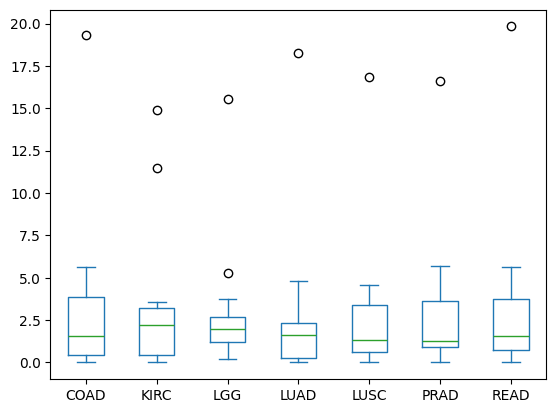

In [31]:
sse_targets.index = outputs_targets['gene_name']
sse_targets.columns = ['BLCA', 'COAD', 'KIRC', 'LGG', 'LUAD', 'LUSC', 'PRAD', 'READ']
import matplotlib.pyplot as plt
plt.figure(figsize=(10,1))
sse_targets.iloc[:, 1:].plot(kind='box')
plt.show()

## GTEx Comparison to COAD/READ Samples

In [54]:
sigmoid_colon = pd.read_csv('/pollard/home/aravi1/GTEx_colon/gene_tpm_2017-06-05_v8_colon_sigmoid.gct.gz', sep='\t', skiprows=2, index_col=0)
transverse_colon = pd.read_csv('/pollard/home/aravi1/GTEx_colon/gene_tpm_2017-06-05_v8_colon_transverse.gct.gz', sep='\t', skiprows=2, index_col=0)

In [55]:
sigmoid_colon.head()

,Name,Description,GTEX-111CU-1226-SM-5EGIN,GTEX-111YS-1826-SM-5GIEP,GTEX-1122O-1426-SM-5H11R,GTEX-117XS-2226-SM-5GIE1,GTEX-117YX-0526-SM-5EGJH,GTEX-11DXX-1926-SM-5EGJK,GTEX-11DXY-2026-SM-5N9CZ,GTEX-11DXZ-1626-SM-5GIDI,...,GTEX-ZVT3-2826-SM-5GU6A,GTEX-ZVT4-2626-SM-5N9GJ,GTEX-ZVZQ-2626-SM-59HLB,GTEX-ZXES-1726-SM-5E43G,GTEX-ZY6K-1326-SM-5GZWP,GTEX-ZYFD-2226-SM-5E43P,GTEX-ZYFG-1826-SM-5GZWX,GTEX-ZYT6-2826-SM-5GICX,GTEX-ZYY3-2226-SM-5E45A,GTEX-ZZ64-0826-SM-5E449
id,,,,,,,,,,,,,,,,,,,,,
0,ENSG00000223972.5,DDX11L1,0.0000,0.0303,0.000,0.000,0.0000,0.0247,0.0619,0.000,...,0.000,0.0406,0.0173,0.00,0.0312,0.0443,0.00,0.0000,0.0328,0.000
1,ENSG00000227232.5,WASH7P,1.9090,2.6480,3.528,7.657,1.9560,4.8910,7.4950,4.811,...,7.432,5.3660,2.8850,3.37,7.7910,5.1670,3.71,6.5040,7.7340,4.077
2,ENSG00000278267.1,MIR6859-1,0.0000,0.0000,0.000,0.000,0.0000,0.0000,0.0000,0.000,...,0.000,0.0000,0.0000,0.00,0.0000,0.0000,0.00,0.0000,0.0000,0.000
3,ENSG00000243485.5,MIR1302-2HG,0.0000,0.0000,0.000,0.000,0.0588,0.0493,0.0000,0.000,...,0.000,0.0000,0.0346,0.00,0.0000,0.0000,0.00,0.0669,0.0655,0.000
4,ENSG00000237613.2,FAM138A,0.0433,0.0000,0.000,0.000,0.0000,0.0000,0.0000,0.000,...,0.000,0.0000,0.0246,0.00,0.0000,0.0314,0.00,0.0000,0.0466,0.000


In [56]:
gene_names = pd.read_csv("crc_gene_counts.tsv", sep="\t")
gene_names = gene_names[['gene_id', 'gene_name', 'gene_type']]

COAD_READ_counts = pd.concat([gene_names, COAD_READ_counts], axis=1)

In [57]:
intersection = set(COAD_READ_counts['gene_id']).intersection(set(sigmoid_colon['Name']))

COAD_READ_counts = COAD_READ_counts[COAD_READ_counts['gene_id'].isin(intersection)]
sigmoid_colon = sigmoid_colon[sigmoid_colon['Name'].isin(intersection)]
transverse_colon = transverse_colon[transverse_colon['Name'].isin(intersection)]


In [58]:
COAD_READ_counts.head()

,gene_id,gene_name,gene_type,90c9f8cd-4c8c-4f07-af2f-e17db69bd561,0f35c851-1cb8-4f75-a661-eae9111b7362,ff11a9e3-d32b-431b-9ebb-c5a3d9eb0e4f,8ee55a63-4e87-4c00-8012-4c87efdcb7ed,5c3c4b79-0682-4f19-96aa-071316a354d4,05167d53-0b47-4131-bfa4-450b236b9fd5,8a25dfb0-edd0-4a44-9a6b-8f3f761b940c,...,d7319fc1-a636-4786-a026-14e248976391,3d1f89ec-ac0b-40f8-ac89-ed0c2d4967b7,e356598b-7611-492a-98ed-ef2ec1b77b7a,a3380ca6-6c65-4543-9bdf-957b26c1daaf,47661ed9-5c0e-442d-b072-3da8b14fab02,5472fa65-a8e2-4593-abd8-e241d1bdec84,c98732eb-48c4-4554-bdf6-0e9a0a9273ec,9da01737-be8f-4af5-9f8f-47bb892b6339,dfb9c45f-cb52-4e36-b663-1a9e8c7c0b47,ad30e5e1-182b-4758-8e70-53e0bcf78072
9,ENSG00000001167.14,NFYA,protein_coding,48.5043,28.0081,39.9567,27.7257,24.8380,25.7599,62.1740,...,21.2536,27.4046,54.9083,36.2329,11.6275,32.5097,29.3969,20.7166,56.2202,50.6108
22,ENSG00000002549.12,LAP3,protein_coding,261.3388,88.3079,63.4036,132.3426,75.2760,66.8372,93.9943,...,67.9410,83.7403,65.3618,48.3384,32.6673,65.1341,87.6891,161.7793,57.0505,100.0015
29,ENSG00000002822.15,MAD1L1,protein_coding,0.5601,0.0469,0.1180,0.0362,0.0262,0.0603,0.0431,...,0.0828,0.4721,2.5828,0.1246,0.0198,0.1195,0.0351,0.1382,0.0537,0.3190
34,ENSG00000003096.14,KLHL13,protein_coding,0.8565,0.2673,0.6337,4.6981,4.1209,0.1872,45.2646,...,3.0665,0.1238,0.6321,15.6045,0.0409,0.1349,1.8190,0.6951,0.5185,0.4090
35,ENSG00000003137.8,CYP26B1,protein_coding,0.1118,1.1618,1.7436,2.0704,1.4345,1.6506,0.3887,...,9.2689,0.0817,0.5190,0.4190,1.0546,1.6908,0.7092,0.4840,0.1805,0.6352


In [59]:
# Define custom order
custom_order = list(intersection)

# Create a custom sorting key function
def custom_sort_key(row):
    return custom_order.index(row)

# Apply custom sorting
COAD_READ_counts['Custom_Order'] = COAD_READ_counts['gene_id'].apply(custom_sort_key)
COAD_READ_counts = COAD_READ_counts.sort_values(by='Custom_Order').drop(columns=['Custom_Order'])

# Apply custom sorting
sigmoid_colon['Custom_Order'] = sigmoid_colon['Name'].apply(custom_sort_key)
sigmoid_colon = sigmoid_colon.sort_values(by='Custom_Order').drop(columns=['Custom_Order'])

# Apply custom sorting
transverse_colon['Custom_Order'] = transverse_colon['Name'].apply(custom_sort_key)
transverse_colon = transverse_colon.sort_values(by='Custom_Order').drop(columns=['Custom_Order'])

In [60]:
metadata = pd.DataFrame(COAD_READ_counts.columns[3:])
metadata['cohort'] = 'COAD/READ'

sigmoid = pd.DataFrame(sigmoid_colon.columns[2:])
sigmoid['cohort'] = 'sigmoid_colon'

transverse = pd.DataFrame(transverse_colon.columns[2:])
transverse['cohort'] = 'transverse_colon'

metadata = pd.concat([metadata, sigmoid, transverse], axis=0)

In [61]:
COAD_READ_counts.reset_index(inplace=True)
sigmoid_colon.reset_index(inplace=True)
transverse_colon.reset_index(inplace=True)

gtex_counts = pd.concat([COAD_READ_counts.iloc[:,4:], sigmoid_colon.iloc[:,3:], transverse_colon.iloc[:,3:]], axis=1)
gtex_counts = np.log(gtex_counts + 0.00001)

pca = PCA(n_components=20, random_state = 150)
pca.fit(gtex_counts)

explained_variance = pca.explained_variance_ratio_
total_explained_variance = explained_variance.sum()

In [63]:
PCA_df = pd.DataFrame(data=pca.components_.reshape(20,1474).T)

metadata.reset_index(inplace=True)
metadata.rename(columns={0: 'sample_id'}, inplace=True)
new_columns = pd.Series(['PC' + str(int(c) + 1) for c in PCA_df.columns[0:20]])
PCA_df = PCA_df.rename(columns=dict(zip(PCA_df.columns[0:20], new_columns)))
PCA_df = pd.concat([PCA_df, metadata], axis=1)

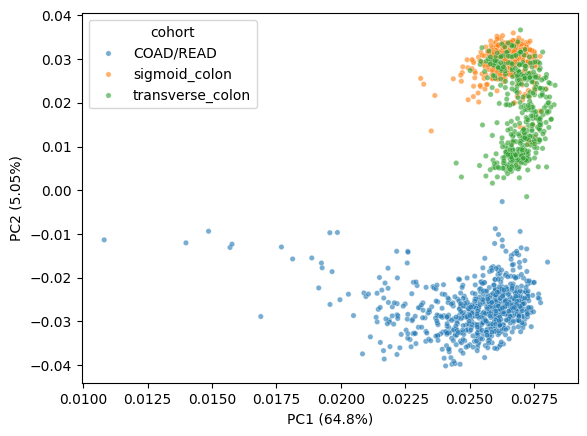

In [64]:
sns.scatterplot(x='PC1', y='PC2', hue='cohort', data=PCA_df, s=15, alpha=0.6) 
plt.xlabel("PC1 (64.8%)")
plt.ylabel("PC2 (5.05%)")
plt.show()

## Accuracies on colon-specific genes

In [67]:
colon_specific_genes = ['MUC2', 'KRT20', 'CDX2', 'ALPI', 'SSTR2', 'SLC26A3', 'FABP6', 
                        'GUCA2B', 'TFF3', 'LGR5', 'CHGA', 'CALB1']

accuracies = pd.Series([-0.11393, 0.48875, -0.15928, -0.47042, -0.10218, -0.15816, -0.18883, 0.4729])
dist_acc_table = pd.concat([pd.Series(read_distances), pd.Series(coad_distances), accuracies, pd.Series(projects)], axis=1)
dist_acc_table.columns = ['READ_distance', 'COAD_distance', 'Accuracy', 'Projects']

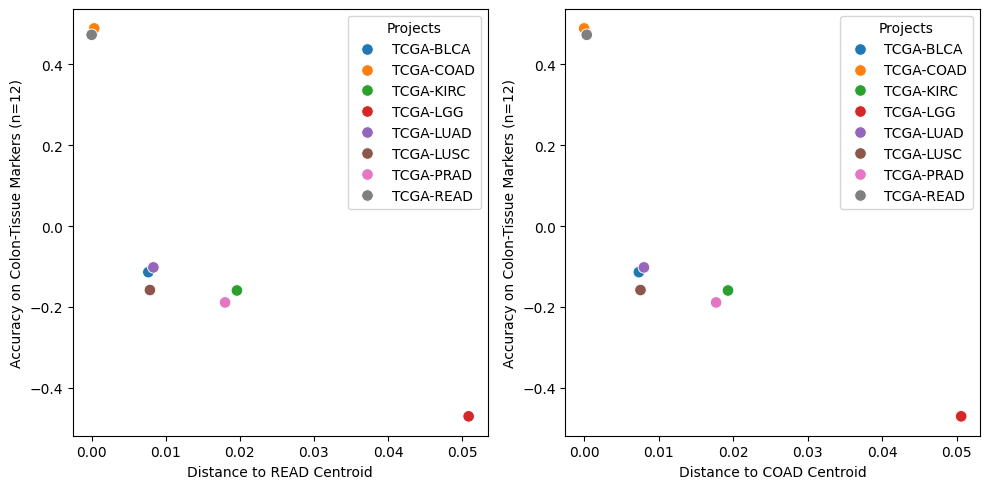

In [69]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.scatterplot(x='READ_distance', y='Accuracy', data=dist_acc_table, hue='Projects', s=70, ax=ax[0])
ax[0].set_xlabel('Distance to READ Centroid')
ax[0].set_ylabel("Accuracy on Colon-Tissue Markers (n=12)")

sns.scatterplot(x='COAD_distance', y='Accuracy', data=dist_acc_table, hue='Projects', s=70, ax=ax[1])
ax[1].set_xlabel('Distance to COAD Centroid')
ax[1].set_ylabel("Accuracy on Colon-Tissue Markers (n=12)")

plt.tight_layout()

# Show plot
plt.show()